# Analysis of DNA-MERFISH for CTP11

by Pu Zheng

2022.02.15

analysis for dataset:

\\10.245.74.158\Chromatin_NAS_0\20220215-P_brain_CTP11-1000_CTP12_from0208

This data is DNA of uncleared MERFISH RNA:
    \\10.245.74.158\Chromatin_NAS_0\20220208-P_brain_M1_nonclear


In [1]:
%run "..\..\Startup_py3.py"
sys.path.append(r"..\..\..\..\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

21224


# 1. Pre-processing info

In [2]:
fov_param = {'data_folder':r'\\10.245.74.158\Chromatin_NAS_5\20220419-P_brain_CTP11-13_from_0415storm65',
             'save_folder':r'\\mendel\Mendel_SSD4\Pu_Temp\20220419-CTP11-13_from_0415storm65',
             'experiment_type': 'DNA',
             'num_threads': 44,
             'correction_folder':r'\\10.245.74.158\Chromatin_NAS_0\Corrections\20210621-Corrections_lumencor_from_60_to_50',
             'shared_parameters':{
                     'single_im_size':[50,2048,2048],
                     'distance_zxy': [250, 108, 108],
                     'corr_channels':['750','647','561'],
                     'num_empty_frames': 0, 
                     'num_buffer_frames':0,
                     'corr_hot_pixel':True,
                     'corr_Z_shift':False,
                     'corr_bleed':True,
                     'min_num_seeds':5,
                     'max_num_seeds': 20000,
                     'spot_seeding_th': 800,
                     'normalize_intensity_local':False,
                     'normalize_intensity_background':False,
                     'corr_gaussian_highpass':False,
                 }, 
             }

## 1.1 define required floders

In [3]:
save_folder = fov_param['save_folder']

save_filenames = [os.path.join(save_folder, _fl) for _fl in os.listdir(save_folder)
                  if _fl.split(os.extsep)[-1]=='hdf5']
# extract fov_id
save_fov_ids = [int(os.path.basename(_fl).split('.hdf5')[0].split('_')[-1]) for _fl in save_filenames]

debug = False

print(f"{len(save_filenames)} fovs detected")

segmentation_folder = os.path.join(save_folder, 'Segmentation')
if not os.path.exists(segmentation_folder):
    os.makedirs(segmentation_folder)
    print(f"Creating segmentation_folder: {segmentation_folder}")
else:
    print(f"Use segmentation_folder: {segmentation_folder}")

cand_spot_folder = os.path.join(save_folder, 'CandSpots')
if not os.path.exists(cand_spot_folder):
    os.makedirs(cand_spot_folder)
    print(f"Creating cand_spot_folder: {cand_spot_folder}")
else:
    print(f"Use cand_spot_folder: {cand_spot_folder}")

decoder_folder = cand_spot_folder.replace('CandSpots', 'Decoder')
if debug:
    _version = 0
    while os.path.exists(os.path.join(decoder_folder, f'v{_version}')):
        _version += 1
    decoder_folder = os.path.join(decoder_folder, f'v{_version}')
if not os.path.exists(decoder_folder):
    os.makedirs(decoder_folder)
    print(f"Creating decoder_folder: {decoder_folder}")
else:
    print(f"Use decoder_folder: {decoder_folder}")


217 fovs detected
Use segmentation_folder: \\mendel\Mendel_SSD4\Pu_Temp\20220419-CTP11-13_from_0415storm65\Segmentation
Use cand_spot_folder: \\mendel\Mendel_SSD4\Pu_Temp\20220419-CTP11-13_from_0415storm65\CandSpots
Use decoder_folder: \\mendel\Mendel_SSD4\Pu_Temp\20220419-CTP11-13_from_0415storm65\Decoder


In [4]:
pixel_sizes = np.array(fov_param['shared_parameters']['distance_zxy'])
single_im_size = np.array(fov_param['shared_parameters']['single_im_size'])
intensity_th = np.array(fov_param['shared_parameters']['spot_seeding_th'])

save_fov_ids = save_fov_ids[:65]
save_filenames = save_filenames[:65]

# 2. Translate segmentation

## 2.1 load rotation matrix

In [40]:
# MERFISH segmentation
merfish_segmentation_folder = r'\\mendel\Mendel_SSD3\MERFISH_Analysis\20220415-storm65\CellPoseSegment\features'
merfish_dapi_folder = os.path.join(save_folder, 'Merfish_DAPI')
if not os.path.exists(merfish_dapi_folder):
    os.makedirs(merfish_dapi_folder)
# generate alignment
rna_data_folder = r'\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65'
rna_alignment_file = os.path.join(rna_data_folder, 'Alignment', '10x_positions_before.txt')
dna_alignment_file = os.path.join(fov_param['data_folder'], 'Alignment', '10x_positions_after.txt')
print(rna_alignment_file, '\n', dna_alignment_file)
print(os.path.exists(rna_alignment_file), os.path.exists(dna_alignment_file))
R, t = ia.correction_tools.alignment.align_manual_points(rna_alignment_file, dna_alignment_file,
                                                         save_folder=save_folder)

\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Alignment\10x_positions_before.txt 
 \\10.245.74.158\Chromatin_NAS_5\20220419-P_brain_CTP11-13_from_0415storm65\Alignment\10x_positions_after.txt
True True
- Manually picked points aligned, rotation:
[[ 0.99909047  0.04264068]
 [-0.04264068  0.99909047]],
 translation:[-176.23722613 -344.28486736]
-- rotation matrix saved to file:\\mendel\Mendel_SSD4\Pu_Temp\20220419-CTP11-13_from_0415storm65\rotation
-- translation matrix saved to file:\\mendel\Mendel_SSD4\Pu_Temp\20220419-CTP11-13_from_0415storm65\translation


In [36]:
np.arccos(R[0,1])

1.5281427161079555

In [ ]:
_sel_fine_angle/180 * math.pi 

# align globally

In [6]:
rna_global_position_fl = os.path.join(rna_data_folder, 'Experiments', 'positions_all.txt')
rna_global_positions = np.loadtxt(rna_global_position_fl, delimiter=',')

In [7]:
# load labels
segmentation_labels = [os.path.join(rna_data_folder, 'Segmentation', _fl) 
                       for _fl in os.listdir(os.path.join(rna_data_folder, 'Segmentation'))
                       if 'segmentation_label' in _fl]

In [8]:
segmentation_labels = [_fl for _fl in sorted(segmentation_labels, 
                                             key=lambda f:int(os.path.basename(f).split(os.extsep)[0].split('_')[-1])) ]

In [9]:
fovID_2_labels = {}
for _fl in segmentation_labels[:1]:
    _fov_id = int(os.path.basename(_fl).split(os.extsep)[0].split('_')[-1])
    _labels = np.load(_fl)
    fovID_2_labels[_fov_id] = _labels

In [ ]:
# load dapi_image
rna_dapi_folder = os.path.join(rna_data_folder,, 'H0M1')
rna_folders, rna_fovs = ia.lib
# list fovs


In [ ]:
rna_f

In [132]:
sel_fov_centers = np.array([_p for _i, _p in enumerate(rna_global_positions) if _i in fovID_2_labels])
print(sel_fov_centers)

[[-1147.7 -2814.6]]


In [133]:
# determine image boundaries
pixel_in_micron = 0.108
layer_size = (2048,2048)
# detect boundaries
lower_lims = np.min(sel_fov_centers - np.array(layer_size)/2 * pixel_in_micron, axis=0)
upper_lims = np.max(sel_fov_centers + np.array(layer_size)/2 * pixel_in_micron, axis=0)

# calculate pixels in each dimension
mosiac_size = np.ceil((upper_lims - lower_lims)/pixel_in_micron).astype(np.int32)
mosiac = np.zeros(mosiac_size, dtype=np.uint16)
#print(lower_lims, upper_lims)
for _ifov, _labels in fovID_2_labels.items():
    _center_micron = rna_global_positions[_ifov]
    _center_pixel = np.ceil((_center_micron - lower_lims)/pixel_in_micron).astype(np.int32)
    _lpxl, _upxl = (_center_pixel - np.array(layer_size)/2).astype(np.int32), (_center_pixel + np.array(layer_size)/2).astype(np.int32)
    mosiac[np.arange(_lpxl[0], _upxl[0]), np.arange(_lpxl[1], _upxl[1])[:, np.newaxis]] += _labels.max(0)
    print(_center_pixel)

[1025 1025]


In [61]:

folders, fovs = ia.io_tools.data.get_folders(rna_data_folder)
dapi_image_file = os.path.join(data_folder, 'H0M1', 'Conv_zscan_005.dax')

Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 12
- Number of field of views: 217


In [62]:
reload(ia.classes.preprocess)
ia.classes.preprocess.DaxProcesser._FindGlobalPosition(dapi_image_file)

array([ -947.7, -2814.6])

In [63]:
# load bit1 position

array([ -947.7, -2814.6])

In [72]:
dna_global_position_fl = os.path.join(fov_param['data_folder'], 'Alignment', 'adjusted_translated_positions_all.txt')
dna_global_positions = np.loadtxt(dna_global_position_fl, delimiter=',')

In [74]:
dna_folders, dna_fovs = ia.io_tools.data.get_folders(fov_param['data_folder'])

Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 68
- Number of field of views: 217


In [121]:
# transpose with microscope
from ImageAnalysis3.segmentation_tools.cell import Align_Segmentation
dna_microscope_file = r'\\mendel\pu_documents\Merfish_analysis\Merfish_Analysis_Scripts\merlin_parameters\microscope\storm6_microscope.json'
dna_microscope_params = Align_Segmentation._read_microscope_json(dna_microscope_file)
dna_microscope_params

{'flip_horizontal': False,
 'flip_vertical': True,
 'transpose': True,
 'microns_per_pixel': 0.108}

In [233]:
import math
_angle = -0./180 * math.pi 
_test_R = np.array([[np.cos(_angle), -np.sin(_angle)],
                    [np.sin(_angle), np.cos(_angle)]])

In [196]:
_fov_id = 0
_sel_bit = 0
for _fov_id in fovID_2_labels:

    with h5py.File(os.path.join(fov_param['save_folder'], dna_fovs[_fov_id].replace('.dax', '.hdf5')), 'r') as _f:
        _combo_spots = [_s[_s[:,0]>0] for _s in _f['combo/spots'][:]]

    xy_coords_pixel = _combo_spots[_sel_bit][:,2:4] - np.array([1024,1024])
    if dna_microscope_params['transpose']:
        xy_coords_pixel = np.fliplr(xy_coords_pixel)

    if dna_microscope_params['flip_horizontal']:
        xy_coords_pixel[:,-1] *= -1
    if dna_microscope_params['flip_vertical']:
        xy_coords_pixel[:,-2] *= -1

    # convert into micron
    xy_coords_micron = xy_coords_pixel * 0.108 + dna_global_positions[_fov_id]
    
    corr_coords_micron = xy_coords_micron @ R.T - t 
    corr_coords_pixel = (corr_coords_micron - lower_lims ) / 0.108

In [235]:
test_coords = _combo_spots[0][:,2:4].copy() - np.array([1024,1024])
if dna_microscope_params['transpose']:
    test_coords = np.fliplr(test_coords)

if dna_microscope_params['flip_horizontal']:
    test_coords[:,-1] *= -1
if dna_microscope_params['flip_vertical']:
    test_coords[:,-2] *= -1

test_coords = test_coords @ _test_R + np.array([1024,1024]) + np.array([21.4,33.7])

<IPython.core.display.Javascript object>


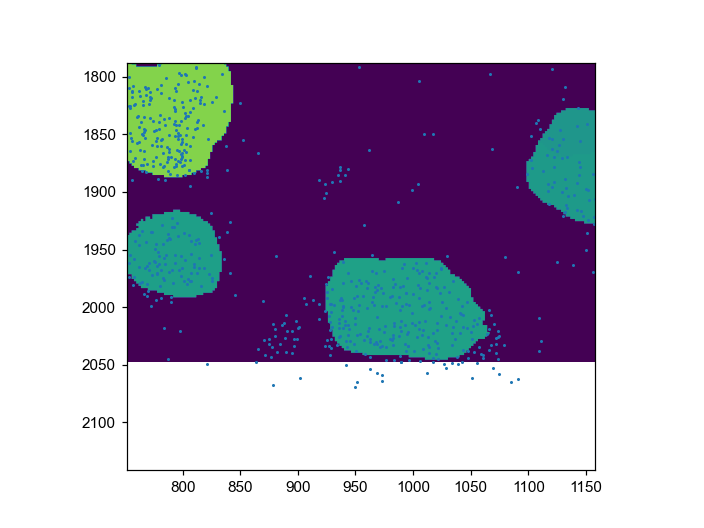

In [236]:
plt.figure()
plt.imshow(fovID_2_labels[_fov_id].max(0))
plt.scatter(test_coords[:,1], test_coords[:,0], s=1)
plt.show()

<IPython.core.display.Javascript object>


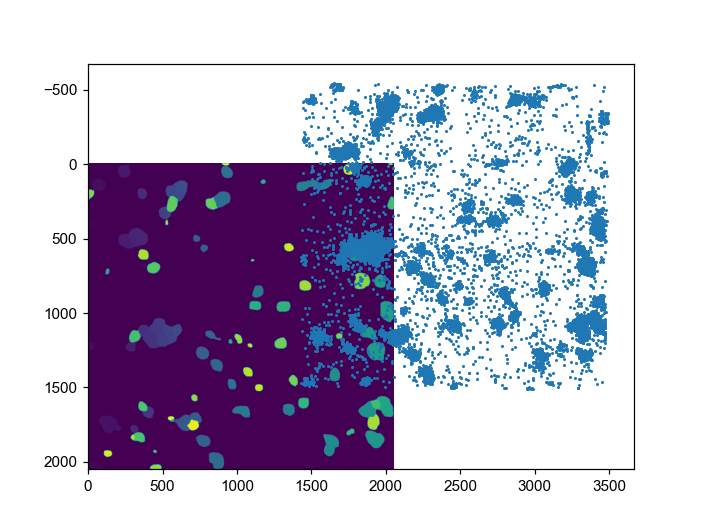

In [185]:
plt.figure()
plt.imshow(mosiac)
plt.scatter(corr_coords_pixel[:,0], corr_coords_pixel[:,1], s=1)
plt.show()

In [31]:
print(mosiac_size)

[3900 7604]


In [163]:
dna_global_positions[0] @ R.T - t, rna_global_positions[0]

(array([-1162.03548718, -2806.82629809]), array([-1147.7, -2814.6]))

## 2.2 save DAPI image for RNA

In [10]:
from tqdm import tqdm
rna_fds, rna_fovs = ia.io_tools.data.get_folders(rna_data_folder)
ref_fd = rna_fds[0]

Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 12
- Number of field of views: 217


In [11]:
overwrite_dapi = False
for _fov_id in tqdm(save_fov_ids):
    _dapi_savefile = os.path.join(merfish_dapi_folder, rna_fovs[_fov_id].replace('.dax', '_Dapi.npy'))
    if overwrite_dapi or not os.path.exists(_dapi_savefile):
        # load 
        _im = ia.visual_tools.DaxReader(os.path.join(ref_fd, rna_fovs[_fov_id])).loadAll()
        _dapi_im = _im[3::4]
        # save
        np.save(_dapi_savefile.split('.npy')[0], _dapi_im)

100%|███████████████████████████████████████████████████████████████████████████████| 217/217 [00:00<00:00, 943.42it/s]


## 2.3 Prepare args

In [12]:
segmentation_savefiles = []

In [13]:
import multiprocessing as mp
# savefile for segmentations
#_total_seg_save_file = os.path.join(segmentation_folder, 'full_segmentation.hdf5')
# required parameters
rna_microscope_file = r'\\mendel\pu_documents\Merfish_analysis\Merfish_Analysis_Scripts\merlin_parameters\microscope\storm65_microscope.json'
dna_microscope_file = r'\\mendel\pu_documents\Merfish_analysis\Merfish_Analysis_Scripts\merlin_parameters\microscope\storm6_microscope.json'
Zcoords = np.arange(0,12.5,0.25) # z-coordinates of all z-planes in this experiment
seg_align_params = {}
overwrite_segmentation = False
plot_segmentation = True

In [41]:
%%time
# initiate locks
_manager = mp.Manager()
# savefile lock
#_segmentation_savefile_lock = _manager.RLock()
_segmentation_savefile_lock = None # do not use lock if saved in multiple files
_seg_align_args = []
# prepare kwargs
for _fov_id, _save_filename in zip(save_fov_ids, save_filenames):
    # segmentation filename
    _segmentation_savefile = os.path.join(segmentation_folder, 
        os.path.basename(_save_filename).replace('.hdf5', '_Segmentation.hdf5') )
    _rna_feature_filename = os.path.join(merfish_segmentation_folder, f"feature_data_{_fov_id}.hdf5")
    _rna_dapi_filename = os.path.join(merfish_dapi_folder, 
                                      os.path.basename(_save_filename).replace('.hdf5', '_Dapi.npy'))
    _args = (_fov_id, Zcoords, _rna_feature_filename, _rna_dapi_filename,
             _save_filename, rna_microscope_file, dna_microscope_file, R, 
             _segmentation_savefile, True, _segmentation_savefile_lock, 
             seg_align_params, plot_segmentation, overwrite_segmentation, False, False, True,
             )
    _seg_align_args.append(_args)
print(len(_seg_align_args))

217
Wall time: 234 ms


## 2.4 test run and plot

In [15]:
rna_dapi = np.load(_seg_align_args[0][3])

In [16]:
with h5py.File(_seg_align_args[0][4], 'r') as _f:
    dna_dapi = _f.attrs['dapi_im']

<IPython.core.display.Javascript object>


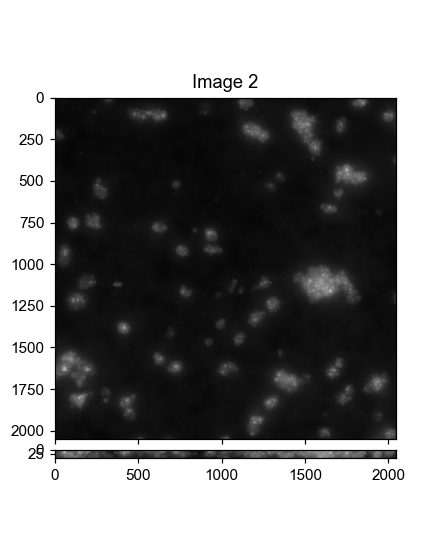

In [17]:
visual_tools.imshow_mark_3d_v2([rna_dapi, dna_dapi])

In [21]:
import ImageAnalysis3.segmentation_tools.cell
reload(ia.segmentation_tools.cell)
align_dna_dapi = ia.segmentation_tools.cell.Align_Segmentation._correct_image3D_by_microscope_param(dna_dapi, 
    io_tools.parameters._read_microscope_json(dna_microscope_file))
align_rna_dapi = ia.segmentation_tools.cell.Align_Segmentation._correct_image3D_by_microscope_param(rna_dapi, 
    io_tools.parameters._read_microscope_json(rna_microscope_file))

<IPython.core.display.Javascript object>


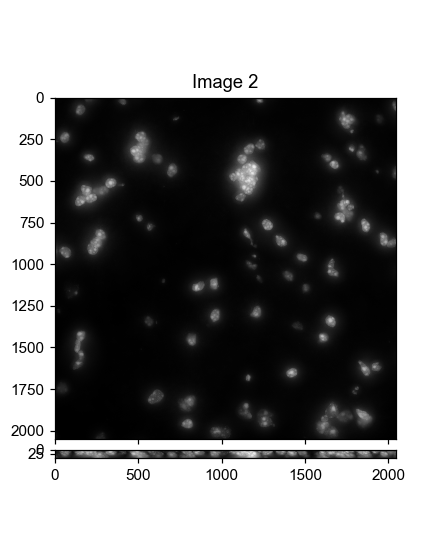

In [22]:
visual_tools.imshow_mark_3d_v2([align_dna_dapi, align_rna_dapi])

In [37]:
import math
_sel_fine_angle = -0.2
_angle = _sel_fine_angle/180 * math.pi 
_test_R = np.array([[np.cos(_angle), -np.sin(_angle)],
                    [np.sin(_angle), np.cos(_angle)]])
print(_test_R)
rot_dna_dapi_im, _rot, _dft = ia.correction_tools.alignment.calculate_translation(align_rna_dapi, align_dna_dapi, _test_R)

[[ 0.99999391  0.00349065]
 [-0.00349065  0.99999391]]
-- start calculating drift with rotation between images
-- start aligning given source image to given reference image.
-- drift 0: [ 0.3 20.5 35.4] in 1.613s.
-- drift 1: [ 0.7 18.1 33. ] in 1.575s.
-- drift 2: [ 0.2  0.3 39.8] in 1.570s.
-- drift 3: [ 0.4 18.5 30.1] in 1.619s.
-- drift 4: [-0.4  2.4  0.2] in 1.586s.
-- drift 5: [ 0.5 17.5 32.3] in 1.609s.
-- drift 6: [ 0.3 20.1 29.5] in 1.603s.
-- drift 7: [ 0.2  8.2 33. ] in 1.592s.
-- return a sub-optimal drift
--- drift: [ 0.53 18.03 31.8 ] pixels


<IPython.core.display.Javascript object>


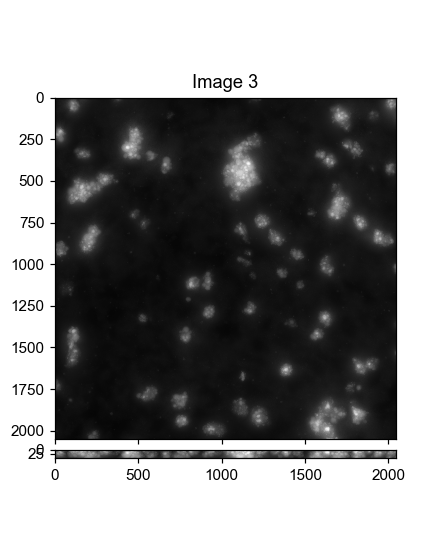

In [38]:
visual_tools.imshow_mark_3d_v2([align_dna_dapi, align_rna_dapi, rot_dna_dapi_im])

In [42]:
import ImageAnalysis3.segmentation_tools.cell
sel_fov = 1
_seg_cls = ia.segmentation_tools.cell.Align_Segmentation(
    _seg_align_args[sel_fov][2],_seg_align_args[sel_fov][3],_seg_align_args[sel_fov][4],
    rna_microscope_file, dna_microscope_file, _test_R, debug=True, 
)

_dna_mask, _full_rna_mask, _rna_dapi, _rot_rna_dapi, _dna_dapi = _seg_cls._generate_dna_mask(_seg_align_args[sel_fov][1]) 

- reconstruct 50 layers
-- start calculating drift with rotation between images
-- start aligning given source image to given reference image.
-- drift 0: [ 0.1  8.2 18.2] in 1.744s.
-- drift 1: [ 0.1  6.2 14.5] in 1.696s.
-- drift 2: [ 0.2  2.3 21.4] in 1.655s.
-- drift 3: [ 0.2  8.7 10.2] in 1.637s.
-- drift 4: [ 0.   7.9 14. ] in 1.697s.
-- drift 5: [ 0.1  6.8 18.2] in 1.602s.
-- drift 6: [ 0.1 10.5 10.7] in 1.596s.
-- drift 7: [ 0.1  0.2 20.6] in 1.624s.
-- return a sub-optimal drift
--- drift: [ 0.1   7.07 16.97] pixels
- generate rotation matrix
- rotate segmentation label with rotation matrix


In [89]:
start_angle = np.arcsin(_seg_cls.rotation_mat[0,1])/math.pi*180

In [164]:
_sft_rna_dapi_max = scipy.ndimage.shift(rna_dapi_max, [0,25])

<IPython.core.display.Javascript object>


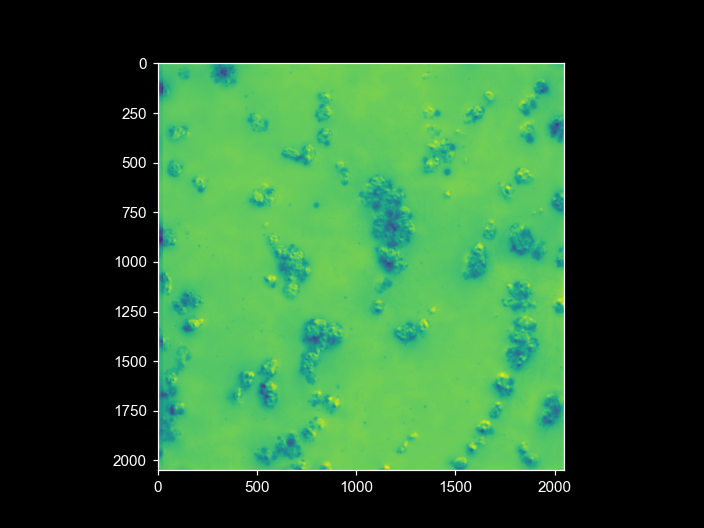

In [165]:
plt.figure()
plt.imshow(_sft_rna_dapi_max-dna_dapi_max)
plt.show()

In [229]:
_seg_cls.rna_dapi_file, _seg_cls.dna_save_file

('J:\\Pu_Temp\\20220419-CTP11-13_from_0415storm65\\Merfish_DAPI\\Conv_zscan_002_Dapi.npy',
 'J:\\Pu_Temp\\20220419-CTP11-13_from_0415storm65\\Conv_zscan_002.hdf5')

In [383]:
import ImageAnalysis3.segmentation_tools.cell
sel_fov = 80
_seg_cls = ia.segmentation_tools.cell.Align_Segmentation(
    _seg_align_args[sel_fov][2],_seg_align_args[sel_fov][3],_seg_align_args[sel_fov][4],
    rna_microscope_file, dna_microscope_file, R, debug=True, 
)

_rna_mparam = _seg_cls._read_microscope_json(_seg_cls.rna_microscope_file)
_dna_mparam = _seg_cls._read_microscope_json(_seg_cls.dna_microscope_file)
_rna_dapi = _seg_cls._load_rna_dapi(_seg_cls.rna_dapi_file, _rna_mparam)
_dna_dapi, _fov_id, _fov_name = _seg_cls._load_dna_info(_seg_cls.dna_save_file, _dna_mparam)

import cv2
import math
from skimage.registration import phase_cross_correlation
dna_dapi_max = np.max(_dna_dapi, axis=0)
dna_dapi_max = (dna_dapi_max-np.min(dna_dapi_max)) / (np.max(dna_dapi_max)-np.min(dna_dapi_max))
rna_dapi_max = np.max(_rna_dapi, axis=0)
rna_dapi_max = (rna_dapi_max-np.min(rna_dapi_max)) / (np.max(rna_dapi_max)-np.min(rna_dapi_max))
# downsample
tar_size = (np.array(np.shape(dna_dapi_max))/2).astype(np.int32)
dna_dapi_max = cv2.resize(dna_dapi_max, tar_size)
rna_dapi_max = cv2.resize(rna_dapi_max, tar_size)

<IPython.core.display.Javascript object>


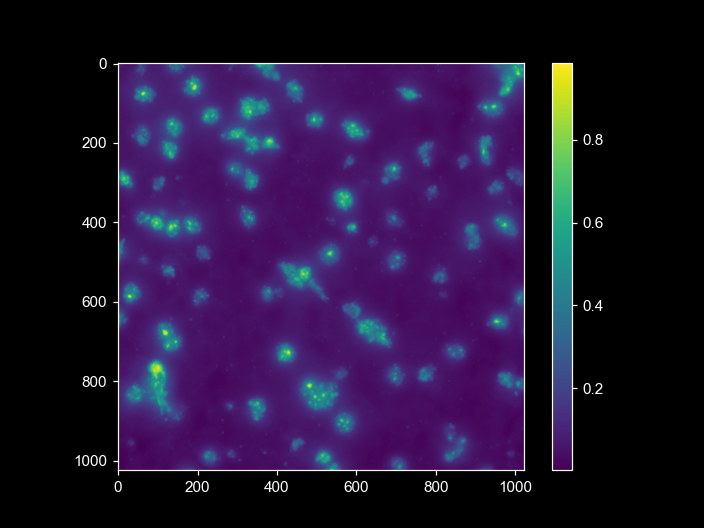

<IPython.core.display.Javascript object>


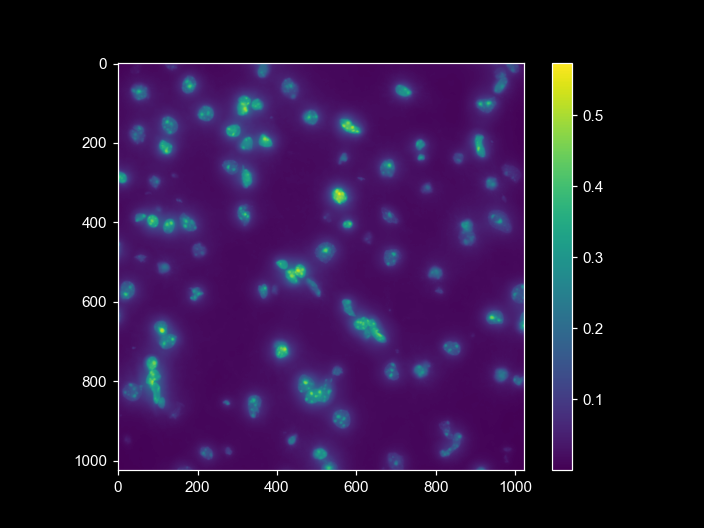

In [384]:
plt.figure()
plt.imshow(dna_dapi_max)
plt.colorbar()
plt.figure()
plt.imshow(rna_dapi_max)
plt.colorbar()

-1.0 [ 0.  -3.8] 1.7412737918220955e-12 0.0005478256960817146
-0.9 [200.8 -11. ] 1.7424950371491832e-12 0.0012024265320732753
-0.8 [206.2 -11. ] 2.261080211951594e-12 3.1405528442348767
-0.7000000000000001 [ 0.  -3.2] 2.244537888884679e-12 0.00032806507528320165
-0.6000000000000001 [ 0.  -1.2] 2.218447647805988e-12 -0.00017204288722617763
-0.5000000000000001 [ 0. -5.] 1.940558824742311e-12 -2.263291253763951e-17
-0.40000000000000013 [0. 0.] 2.419175970658216e-12 -4.8634176537287334e-17
-0.30000000000000016 [ 0.  -4.6] 1.7100765248301286e-12 0.0007077718655971178
-0.20000000000000018 [ 0. -6.] 1.7570389587717727e-12 -0.0
-0.1000000000000002 [0. 0.] 2.6689761511988763e-12 -6.165628043992896e-17
-2.220446049250313e-16 [ 0.  -8.4] 3.029354544992202e-12 0.0009564971091989726
0.09999999999999964 [ -8.4 -10. ] 4.111266882489417e-12 -4.078176116526917e-05
0.19999999999999973 [ -7.6 -10. ] 5.718869822146644e-12 -0.00021727416833304135
0.2999999999999998 [ -7.8 -10. ] 5.8507643174721125e-12 5.09

<IPython.core.display.Javascript object>


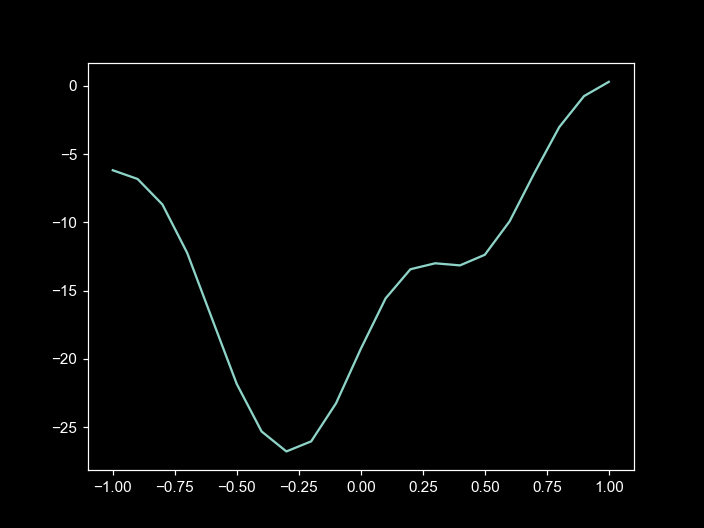

-0.40000000000000013 [-0.1  0.1] 2.470357252093436e-12 1.5023605546281538e-05
-0.3900000000000001 [ 0.  -4.7] 2.4330537584660306e-12 0.0012893289330275393
-0.3800000000000001 [ 0.  -4.8] 2.1934676297519218e-12 -0.0005327022942232356
-0.3700000000000001 [ 0.  -4.7] 2.0317081350640365e-12 -0.0011255639001615128
-0.3600000000000001 [ 0.  -5.1] 2.0431434322176756e-12 0.0003671732433148324
-0.3500000000000001 [ 0.  -4.6] 2.0445867221496883e-12 -0.0004949665340300539
-0.3400000000000001 [ 0.  -4.8] 2.1873614031164834e-12 -0.00016813983668705898
-0.33000000000000007 [ 0.  -4.6] 2.2332136140335024e-12 0.0008717813794372045
-0.32000000000000006 [ 0.  -4.7] 1.9675372442407024e-12 0.0007357656412079977
-0.31000000000000005 [-0.1 -4.7] 1.914690628268545e-12 0.001169397110631064
-0.30000000000000004 [ 0.  -4.5] 1.7106316363424412e-12 0.0007440710179313735
-0.29000000000000004 [-348.     6.2] 2.7700064464397656e-12 -0.000663607192100464
-0.28 [ 0.  -5.1] 2.2276624989103766e-12 -8.373472262273702e-05

<IPython.core.display.Javascript object>


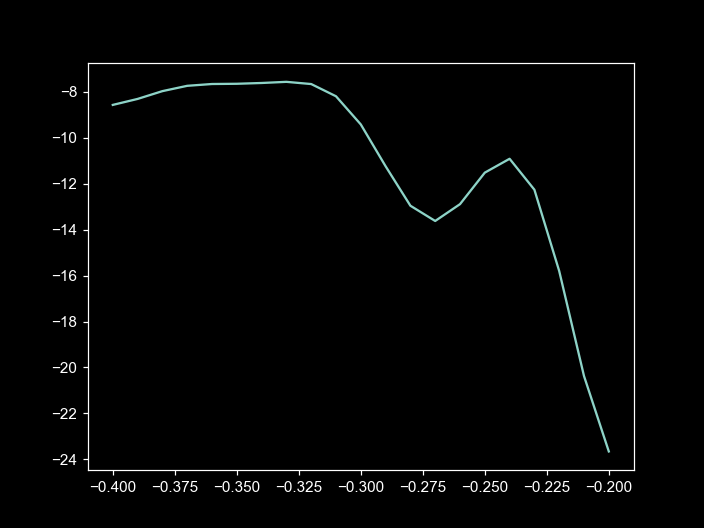

In [385]:
# step1 coarse_search
start_angle = 0
coarse_search_range = 1
coarse_search_step = 0.1
fine_search_range = 0.11
fine_search_step = 0.01
upsample_factor = 5

_dx, _dy = np.shape(dna_dapi_max)

_coarse_angles = np.arange(start_angle-coarse_search_range, 
                           start_angle+coarse_search_range+coarse_search_step, 
                           coarse_search_step)

all_shifts, all_errors, all_diffs = [],[],[]

for _agl in _coarse_angles:
    _rotation_M = cv2.getRotationMatrix2D((_dx/2, _dy/2), _agl, 1)
    _rot_dna_dapi_max = cv2.warpAffine(dna_dapi_max,
                                       _rotation_M, 
                                       dna_dapi_max.shape, 
                                       flags=cv2.INTER_NEAREST,
                                       borderMode=cv2.BORDER_CONSTANT)
    # align
    _sft, _err, _diff = phase_cross_correlation(rna_dapi_max, _rot_dna_dapi_max, upsample_factor=upsample_factor)
    all_shifts.append(_sft)
    all_errors.append(_err)
    all_diffs.append(_diff)
    print(_agl, _sft, np.abs(1-_err), _diff)
    
# find valley for phase_diff
all_diffs = np.array(all_diffs)
coarse_diffs = np.log(np.abs(all_diffs) + np.min(np.abs(all_diffs[np.abs(all_diffs) > 0]))/1e3)
coarse_diffs = scipy.ndimage.gaussian_filter1d(coarse_diffs, 2)
_sel_coarse_angle = _coarse_angles[np.argmin(coarse_diffs)]
print(_sel_coarse_angle)

plt.figure()
plt.plot(_coarse_angles, coarse_diffs)
plt.show()

#_sel_coarse_angle = -0.5

# Fine
_fine_angles = np.arange(_sel_coarse_angle-fine_search_range, 
                         _sel_coarse_angle+fine_search_range+fine_search_step, 
                         fine_search_step)

all_shifts, all_errors, all_diffs = [],[],[]

for _agl in _fine_angles:
    _rotation_M = cv2.getRotationMatrix2D((_dx/2, _dy/2), _agl, 1)
    _rot_dna_dapi_max = cv2.warpAffine(dna_dapi_max,
                                       _rotation_M, 
                                       dna_dapi_max.shape, 
                                       flags=cv2.INTER_NEAREST,
                                       borderMode=cv2.BORDER_CONSTANT)
    # align
    _sft, _err, _diff = phase_cross_correlation(rna_dapi_max, _rot_dna_dapi_max, upsample_factor=upsample_factor*2)
    all_shifts.append(_sft)
    all_errors.append(_err)
    all_diffs.append(_diff)
    print(_agl, _sft, np.abs(1-_err), _diff)
    
all_diffs = np.array(all_diffs)
fine_diffs = np.log(np.abs(all_diffs) + np.min(np.abs(all_diffs[np.abs(all_diffs) > 0]))/1e5)
fine_diffs = scipy.ndimage.gaussian_filter1d(fine_diffs, 2)
_sel_fine_angle = _fine_angles[np.argmin(fine_diffs)]
print(_sel_fine_angle)

plt.figure()
plt.plot(_fine_angles, fine_diffs)
plt.show()

In [386]:
all_shifts = np.array(all_shifts)
fine_dx, fine_dy = all_shifts.transpose()

<IPython.core.display.Javascript object>


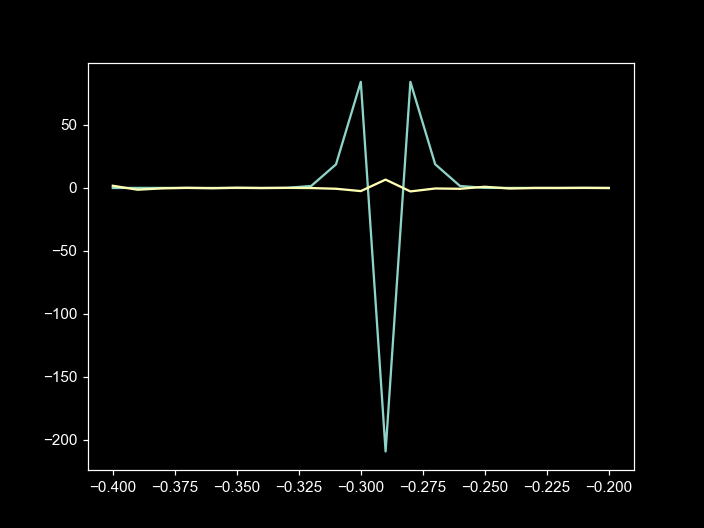

In [387]:
plt.figure()
plt.plot(_fine_angles, fine_dx - scipy.ndimage.gaussian_filter1d(fine_dx, 1))
plt.plot(_fine_angles, fine_dy - scipy.ndimage.gaussian_filter1d(fine_dy, 1))

In [388]:
_sel_coarse_angle = -0.5

# Fine
_fine_angles = np.arange(_sel_coarse_angle-fine_search_range, 
                         _sel_coarse_angle+fine_search_range+fine_search_step, 
                         fine_search_step)

all_shifts, all_errors, all_diffs = [],[],[]

for _agl in _fine_angles:
    _rotation_M = cv2.getRotationMatrix2D((_dx/2, _dy/2), _agl, 1)
    _rot_dna_dapi_max = cv2.warpAffine(dna_dapi_max,
                                       _rotation_M, 
                                       dna_dapi_max.shape, 
                                       flags=cv2.INTER_NEAREST,
                                       borderMode=cv2.BORDER_CONSTANT)
    # align
    _sft, _err, _diff = phase_cross_correlation(rna_dapi_max, _rot_dna_dapi_max, upsample_factor=upsample_factor*2)
    all_shifts.append(_sft)
    all_errors.append(_err)
    all_diffs.append(_diff)
    print(_agl, _sft, np.abs(1-_err), _diff)
    
all_diffs = np.array(all_diffs)
fine_diffs = np.log(np.abs(all_diffs) + np.min(np.abs(all_diffs[np.abs(all_diffs) > 0]))/1e5)
fine_diffs = scipy.ndimage.gaussian_filter1d(fine_diffs, 2)
_sel_fine_angle = _fine_angles[np.argmin(fine_diffs)]
print(_sel_fine_angle)

plt.figure()
plt.plot(_fine_angles, fine_diffs)
plt.show()

-0.6 [ 0.  -1.3] 2.2214452499724757e-12 -0.00023663814580222926
-0.59 [218.2 -11. ] 2.4775737017534993e-12 3.1410487151604136
-0.58 [219.2 -11. ] 3.076872090446159e-12 3.140239604915446


KeyboardInterrupt: 

In [390]:
_angle = _sel_fine_angle/180 * math.pi 
_test_R = np.array([[np.cos(_angle), -np.sin(_angle)],
                    [np.sin(_angle), np.cos(_angle)]])
print(_test_R)
rot_dna_dapi_im, _rot, _dft = ia.correction_tools.alignment.calculate_translation(_rna_dapi, _dna_dapi, _test_R)

array([[ 0.99999391,  0.00349065],
       [-0.00349065,  0.99999391]])

In [391]:
reload(ia.segmentation_tools.cell)
reload(ia.correction_tools.alignment)

<module 'ImageAnalysis3.correction_tools.alignment' from 'E:\\Users\\puzheng\\Documents\\ImageAnalysis3\\correction_tools\\alignment.py'>

In [392]:
rot_dna_dapi_im, _rot, _dft = ia.correction_tools.alignment.calculate_translation(_rna_dapi, _dna_dapi, _test_R)

-- start calculating drift with rotation between images
-- start aligning given source image to given reference image.
-- drift 0: [ 0.  -0.1  0. ] in 4.059s.
-- drift 1: [  1.7 -17.2 -19.9] in 4.570s.
-- drift 2: [  3.  -15.9 -17.7] in 4.807s.
-- drift 3: [  0.2 -14.7 -20.6] in 4.574s.
-- drift 4: [  2.3 -14.7 -18.2] in 4.634s.
-- drift 5: [  0.7 -16.1 -20.5] in 4.561s.
-- drift 6: [  0.7 -14.3 -19.5] in 4.203s.
-- drift 7: [  2.4 -16.5 -18.7] in 4.623s.
-- return a sub-optimal drift
--- drift: [  0.53 -15.03 -20.2 ] pixels


<IPython.core.display.Javascript object>


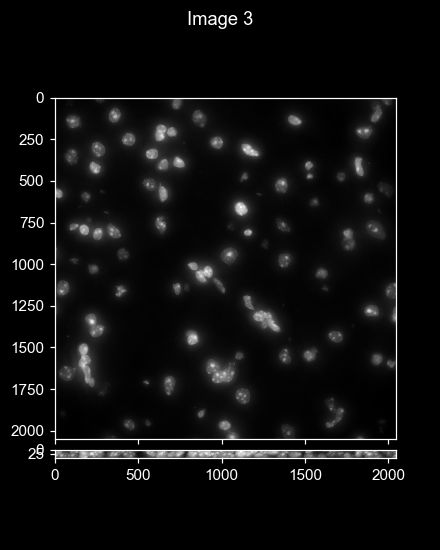

In [393]:
visual_tools.imshow_mark_3d_v2([_dna_dapi, rot_dna_dapi_im, _rna_dapi])

In [271]:
from skimage import util, transform, feature, measure, filters, metrics


In [293]:
cn_feature_dna = feature.corner_peaks(feature.corner_harris(dna_dapi_max), threshold_rel=0.001, min_distance=5)

In [286]:
cn_feature_rna = feature.corner_peaks(feature.corner_harris(rna_dapi_max), threshold_rel=0.0001, min_distance=5)

In [313]:
def match_locations(img0, img1, coords0, coords1, radius=5, sigma=3):
    """Match image locations using SSD minimization.

    Areas from `img0` are matched with areas from `img1`. These areas
    are defined as patches located around pixels with Gaussian
    weights.

    Parameters:
    -----------
    img0, img1 : 2D array
        Input images.
    coords0 : (2, m) array_like
        Centers of the reference patches in `img0`.
    coords1 : (2, n) array_like
        Centers of the candidate patches in `img1`.
    radius : int
        Radius of the considered patches.
    sigma : float
        Standard deviation of the Gaussian kernel centered over the patches.

    Returns:
    --------
    match_coords: (2, m) array
        The points in `coords1` that are the closest corresponding matches to
        those in `coords0` as determined by the (Gaussian weighted) sum of
        squared differences between patches surrounding each point.
    """
    y, x = np.mgrid[-radius:radius + 1, -radius:radius + 1]
    weights = np.exp(-0.5 * (x ** 2 + y ** 2) / sigma ** 2)
    weights /= 2 * np.pi * sigma * sigma

    match_list = []
    for r0, c0 in coords0:
        try:
            roi0 = img0[r0 - radius:r0 + radius + 1, c0 - radius:c0 + radius + 1]
            roi1_list = [img1[r1 - radius:r1 + radius + 1,
                              c1 - radius:c1 + radius + 1] for r1, c1 in coords1]
            # sum of squared differences
            
            ssd_list = [np.sum(weights * (roi0 - roi1) ** 2) for roi1 in roi1_list]
            match_list.append(coords1[np.argmin(ssd_list)])
            print(weights.shape, roi0.shape, roi1_list[0].shape)
        except:
            continue
    return np.array(match_list)
matching_corners = match_locations(rna_dapi_max, dna_dapi_max, cn_feature_rna, cn_feature_dna, 5,)


(11, 11) (11, 11) (11, 11)
(11, 11) (11, 11) (11, 11)
(11, 11) (11, 11) (11, 11)
(11, 11) (11, 11) (11, 11)
(11, 11) (11, 11) (11, 11)
(11, 11) (11, 11) (11, 11)
(11, 11) (11, 11) (11, 11)
(11, 11) (11, 11) (11, 11)
(11, 11) (11, 11) (11, 11)
(11, 11) (11, 11) (11, 11)
(11, 11) (11, 11) (11, 11)
(11, 11) (11, 11) (11, 11)
(11, 11) (11, 11) (11, 11)
(11, 11) (11, 11) (11, 11)
(11, 11) (11, 11) (11, 11)
(11, 11) (11, 11) (11, 11)
(11, 11) (11, 11) (11, 11)
(11, 11) (11, 11) (11, 11)
(11, 11) (11, 11) (11, 11)
(11, 11) (11, 11) (11, 11)
(11, 11) (11, 11) (11, 11)
(11, 11) (11, 11) (11, 11)
(11, 11) (11, 11) (11, 11)
(11, 11) (11, 11) (11, 11)
(11, 11) (11, 11) (11, 11)
(11, 11) (11, 11) (11, 11)
(11, 11) (11, 11) (11, 11)
(11, 11) (11, 11) (11, 11)
(11, 11) (11, 11) (11, 11)
(11, 11) (11, 11) (11, 11)
(11, 11) (11, 11) (11, 11)
(11, 11) (11, 11) (11, 11)
(11, 11) (11, 11) (11, 11)
(11, 11) (11, 11) (11, 11)
(11, 11) (11, 11) (11, 11)
(11, 11) (11, 11) (11, 11)
(11, 11) (11, 11) (11, 11)
(

In [316]:
cn_feature_rna.shape

(125, 2)

In [315]:
matching_corners.shape

(125, 2)

<IPython.core.display.Javascript object>


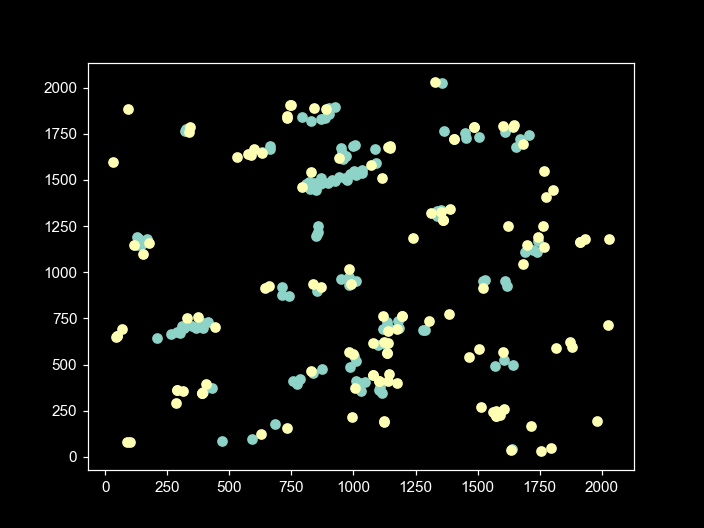

In [321]:
plt.figure()
plt.scatter(cn_feature_rna[:,0], cn_feature_rna[:,1])
plt.scatter(matching_corners[:,0], matching_corners[:,1])
plt.show()

In [322]:

translate_info = measure.ransac((cn_feature_rna, matching_corners),
                            transform.EuclideanTransform, min_samples=3,
                            residual_threshold=10, max_trials=100)

E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\skimage\measure\fit.py:896: UserWarning: No inliers found. Model not fitted
  warn("No inliers found. Model not fitted")


In [323]:
translate_info

(None, None)

In [299]:
cn_feature_dna.shape, cn_feature_rna.shape

((2361, 2), (125, 2))

<IPython.core.display.Javascript object>


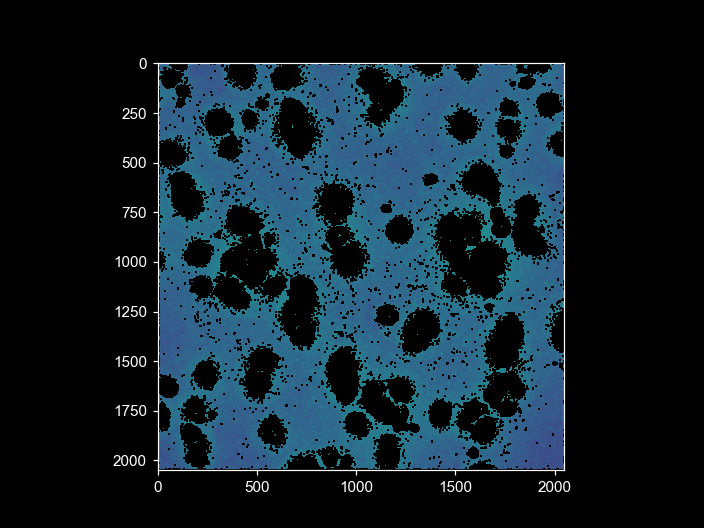

C:\Users\puzheng\AppData\Local\Temp/ipykernel_67656/1886630657.py:2: RuntimeWarning: invalid value encountered in log
  plt.imshow(np.log(cn_feature_rna), )


In [282]:
plt.figure()
plt.imshow(np.log(cn_feature_rna), )
plt.show()

array([[1101,  340],
       [1256,  737],
       [1728, 1087],
       ...,
       [1748,   27],
       [1086, 1509],
       [  30, 1595]], dtype=int64)

In [252]:
_rot_rna, _rot_dna = ia.segmentation_tools.cell.translate_segmentation(_rna_dapi, _dna_dapi, _test_R, 
                                                  label_before=_rna_dapi, return_new_dapi=True,)

-- start calculating drift with rotation between images
-- start aligning given source image to given reference image.
-- drift 0: [   0.  -141.8    0. ] in 2.594s.
-- drift 1: [ 1.000e-01  0.000e+00 -1.617e+02] in 2.610s.
-- drift 2: [ 0.  50.1  0. ] in 2.608s.
-- drift 3: [   0.  -216.1    0. ] in 2.605s.
-- drift 4: [  0.2 147.2   0. ] in 2.599s.
-- drift 5: [0.1 0.  0.1] in 2.604s.
-- drift 6: [  0.    0.  -70.9] in 2.600s.
-- drift 7: [  0.  -92.2   0. ] in 2.670s.
-- return a sub-optimal drift
--- drift: [   0.   -150.03    0.  ] pixels
- generate rotation matrix
- rotate segmentation label with rotation matrix


KeyboardInterrupt: 

<IPython.core.display.Javascript object>


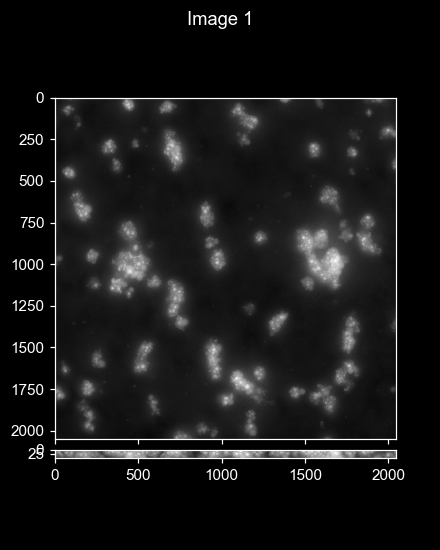

In [270]:
visual_tools.imshow_mark_3d_v2([_dna_dapi, _rot_rna, _rna_dapi])

<IPython.core.display.Javascript object>


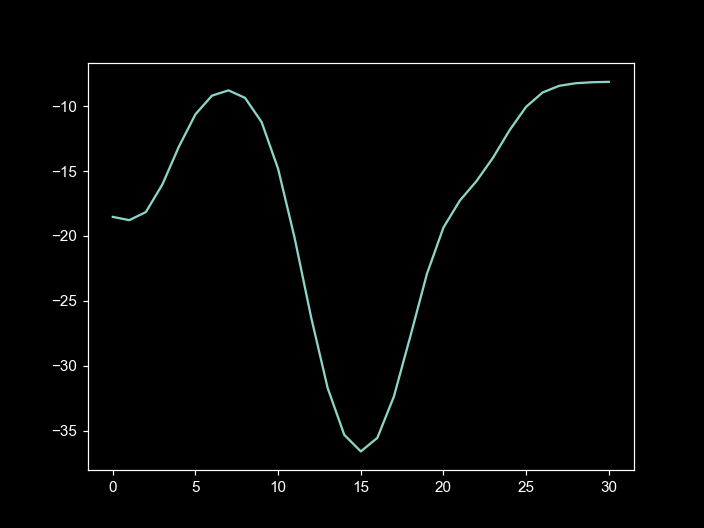

In [216]:
plt.figure()
plt.plot(fine_diffs)
plt.show()

<IPython.core.display.Javascript object>


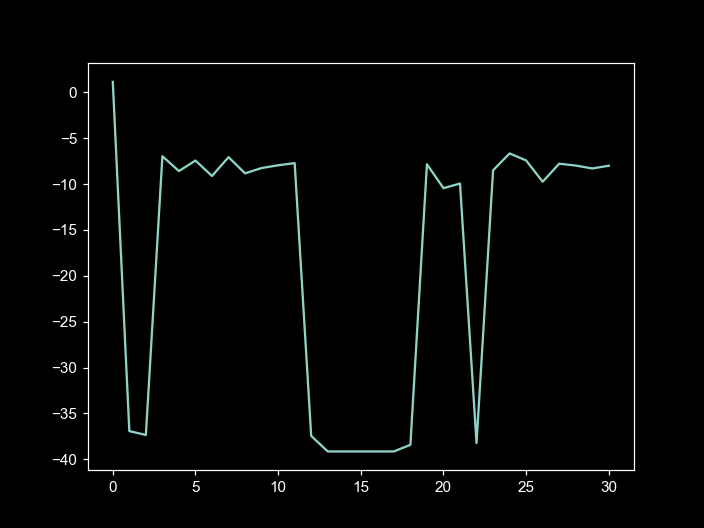

In [214]:
plt.figure()
plt.plot(np.log(np.abs(all_diffs))+1e-20)
plt.show()

In [182]:
%%time 


all_shifts, all_errors, all_diffs = [],[],[]

for _delta_angle in np.arange(-1, 2, 0.1):
    _agl = _delta_angle #+ start_angle
    
    _rotation_M = cv2.getRotationMatrix2D((_dx/2, _dy/2), _agl, 1)
    _rot_dna_dapi_max = cv2.warpAffine(dna_dapi_max,
                                              _rotation_M, 
                                              dna_dapi_max.shape, 
                                              flags=cv2.INTER_NEAREST,
                                              borderMode=cv2.BORDER_CONSTANT)
    # align
    _sft, _err, _diff = phase_cross_correlation(rna_dapi_max, _rot_dna_dapi_max, upsample_factor=5)
    all_shifts.append(_sft)
    all_errors.append(_err)
    all_diffs.append(_diff)
    print(_agl, _sft, _err, _diff)
    

-1.0 [-686.  -722.4] 0.9999999999999908 0.0010319346595449774
-0.9 [500.4 -24. ] 0.9999999999999933 3.140336497371769
-0.8 [-687.  -715.6] 0.9999999999999929 3.1400478801720806
-0.7000000000000001 [543.2 -24. ] 0.9999999999999934 3.1415500393789415
-0.6000000000000001 [481.2 -23. ] 0.9999999999999917 3.140230902197621
-0.5000000000000001 [-690.  -870.2] 0.9999999999999953 -6.34488887143988e-05
-0.40000000000000013 [-689.  -683.8] 0.9999999999999956 3.141264019229016
-0.30000000000000016 [-690.  -757.2] 0.9999999999999972 0.0009071605710418533
-0.20000000000000018 [478.4 -22. ] 0.9999999999999912 3.1413396135632508
-0.1000000000000002 [0.6 0. ] 0.9999999999999956 0.0005901639769197753
-2.220446049250313e-16 [0. 0.] 0.9999999999999827 1.008737439527632e-17
0.09999999999999964 [  0. -18.] 0.9999999999999953 1.1681834131188347e-16
0.19999999999999973 [  0.  -28.2] 0.9999999999999952 0.0009741164321210395
0.2999999999999998 [431.4 -21. ] 0.9999999999999961 3.139406544931277
0.39999999999999

In [175]:
R

array([[ 0.99909047,  0.04264068],
       [-0.04264068,  0.99909047]])

In [106]:
_sft

array([  0., -74.])

In [102]:
    _rotation_M = cv2.getRotationMatrix2D((_dx/2, _dy/2), _agl, 1)
    _rot_dna_dapi_max = cv2.warpAffine(dna_dapi_max,
                                              _rotation_M, 
                                              dna_dapi_max.shape, 
                                              flags=cv2.INTER_NEAREST,
                                              borderMode=cv2.BORDER_CONSTANT)

<IPython.core.display.Javascript object>


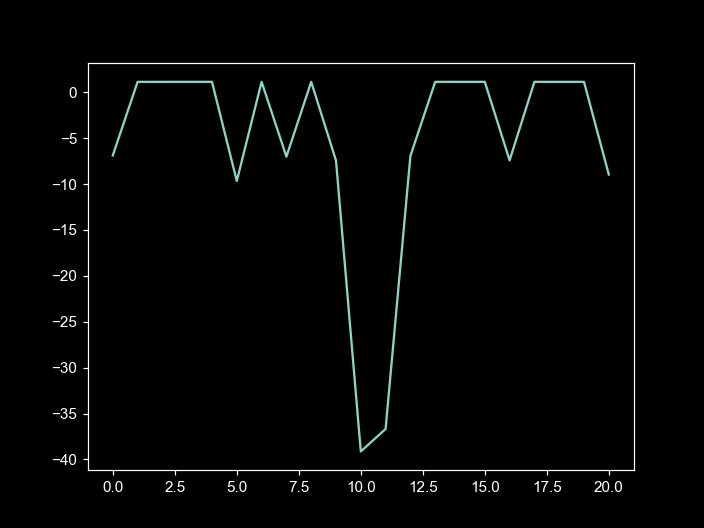

In [64]:
?phase_cross_correlation

<IPython.core.display.Javascript object>


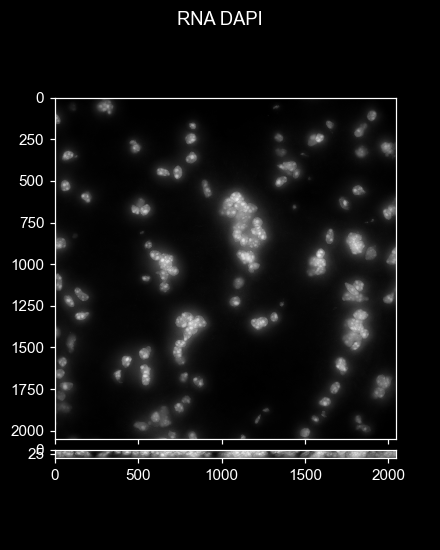

In [56]:
%matplotlib notebook
plt.style.use('dark_background')
_vis = ia.visual_tools.imshow_mark_3d_v2([_dna_dapi, _rna_dapi, _rot_rna_dapi], 
                                         #min_max_default=[10000,50000], 
                                         image_names=['DNA DAPI', 'RNA DAPI', 'Rotated RNA DAPI'])
#_vis.f.savefig(os.path.join(segmentation_folder, 'test_dna_dapi.png'), transparent=True)

<IPython.core.display.Javascript object>


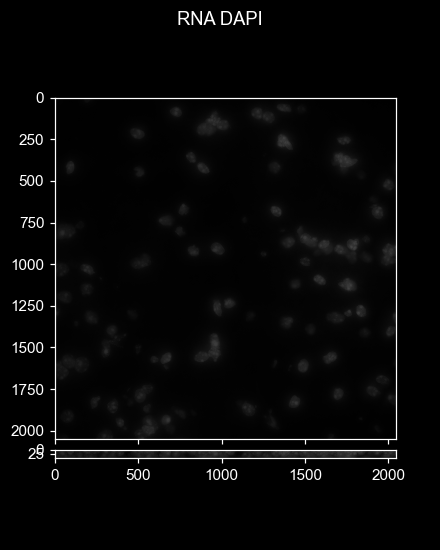

In [33]:
%matplotlib notebook
plt.style.use('dark_background')
_vis = ia.visual_tools.imshow_mark_3d_v2([_rna_dapi], 
                                         #min_max_default=[500,8000], 
                                         image_names=['RNA DAPI'])
_vis.f.savefig(os.path.join(segmentation_folder, 'test_rna_dapi.png'), transparent=True)

## 2.5 batch run translation

In [52]:
%%time
from ImageAnalysis3.segmentation_tools.cell import _batch_align_segmentation
# Multiprocessing
print(f"- Start multiprocessing segmentation alignment", end=' ')
_start_time = time.time()
with mp.Pool(8) as _seg_pool:
    # start multiprocessing
    _seg_pool.starmap(_batch_align_segmentation, _seg_align_args, chunksize=1)
    # close multiprocessing
    _seg_pool.close()
    _seg_pool.join()
    _seg_pool.terminate()
print(f"finish in {time.time()-_start_time:.3f}s. ")

- Start multiprocessing segmentation alignment 

PermissionError: [Errno 13] Permission denied: '\\\\mendel\\Mendel_SSD1\\Pu_Temp\\20220402-P_brain_CTP11-13_from_0329_warp\\Segmentation\\Conv_zscan_000_SegmentationMask.png'

# 3 Partition DNA-MERFISH spots

In [55]:
from ImageAnalysis3.classes.partition_spots import Spots_Partition
from ImageAnalysis3.classes.preprocess import Spots3D
from ImageAnalysis3.figure_tools import plot_partition
import pandas as pd

In [56]:
from ImageAnalysis3.segmentation_tools.cell import Align_Segmentation
import ImageAnalysis3.io_tools.spots 
reload(segmentation_tools.cell)
reload(io_tools.spots)
reload(ia.classes.preprocess)
reload(ia.classes.partition_spots)

<module 'ImageAnalysis3.classes.partition_spots' from 'E:\\Users\\puzheng\\Documents\\ImageAnalysis3\\classes\\partition_spots.py'>

## 3.1 prepare spots for partition


In [57]:
search_radius = 3
overwrite_cand_spots = False
add_relabel_spots = False

#_total_seg_save_file defined in 2.3
_partition_args = []

In [62]:
%%time
for _fov_id, _save_filename in zip(save_fov_ids, save_filenames):
    _segmentation_savefile = os.path.join(segmentation_folder, 
        os.path.basename(_save_filename).replace('.hdf5', '_Segmentation.hdf5') )
    # savename
    _cand_spot_filename = os.path.join(cand_spot_folder,
                                      os.path.basename(_save_filename).replace('.hdf5', f'_CandSpots.csv') )
    if os.path.isfile(_cand_spot_filename) and not overwrite_cand_spots:
        continue
    # load segmentation label matrix and uids
    _align_seg = Align_Segmentation('', '', _save_filename, '', np.array([]))
    _align_seg._load(_segmentation_savefile)
    seg_label, fovcell_2_uid = _align_seg.dna_mask, _align_seg.fovcell_2_uid
    # load spots
    spots_list, combo_bits = ia.io_tools.spots.load_preprocess_spots(
        _save_filename, 'combo', None, pixel_sizes=pixel_sizes,
    )
    # add relabeled spots if specified.
    if add_relabel_spots:
        relabel_spots_list, relabel_bits = ia.io_tools.spots.load_preprocess_spots(
            _save_filename, 'relabeled_combo', None, pixel_sizes=pixel_sizes,
        )
        for _rspots, _rbit in zip(relabel_spots_list, relabel_bits):
            _ind = list(combo_bits).index(_rbit)
            _old_spots = spots_list[_ind]
            # merge
            _merged_spots = ia.io_tools.spots.merge_RelabelSpots(
                _old_spots, _rspots, pixel_sizes=pixel_sizes,
            )
            # replace
            spots_list[_ind] = _merged_spots
    # 
    _all_spots = ia.io_tools.spots.merge_Spots3DList(spots_list, pixel_sizes=pixel_sizes)
    # partition args
    _args = (
        _fov_id, 
        np.array(_all_spots), _all_spots.bits, _all_spots.channels,
        seg_label, fovcell_2_uid,
        search_radius, pixel_sizes,
        True, 
        True, _cand_spot_filename,
        True, 60, 
        False, True,
    )
    _partition_args.append(_args)
    
print(len(_partition_args))

-- loading segmentation info from fov:65 into file: \\mendel\Mendel_SSD1\Pu_Temp\20220402-P_brain_CTP11-13_from_0329_warp\Segmentation\Conv_zscan_065_Segmentation.hdf5
-- loading segmentation info from fov:66 into file: \\mendel\Mendel_SSD1\Pu_Temp\20220402-P_brain_CTP11-13_from_0329_warp\Segmentation\Conv_zscan_066_Segmentation.hdf5
-- loading segmentation info from fov:67 into file: \\mendel\Mendel_SSD1\Pu_Temp\20220402-P_brain_CTP11-13_from_0329_warp\Segmentation\Conv_zscan_067_Segmentation.hdf5
-- loading segmentation info from fov:68 into file: \\mendel\Mendel_SSD1\Pu_Temp\20220402-P_brain_CTP11-13_from_0329_warp\Segmentation\Conv_zscan_068_Segmentation.hdf5
-- loading segmentation info from fov:69 into file: \\mendel\Mendel_SSD1\Pu_Temp\20220402-P_brain_CTP11-13_from_0329_warp\Segmentation\Conv_zscan_069_Segmentation.hdf5
-- loading segmentation info from fov:70 into file: \\mendel\Mendel_SSD1\Pu_Temp\20220402-P_brain_CTP11-13_from_0329_warp\Segmentation\Conv_zscan_070_Segmentati

-- loading segmentation info from fov:114 into file: \\mendel\Mendel_SSD1\Pu_Temp\20220402-P_brain_CTP11-13_from_0329_warp\Segmentation\Conv_zscan_114_Segmentation.hdf5
-- loading segmentation info from fov:115 into file: \\mendel\Mendel_SSD1\Pu_Temp\20220402-P_brain_CTP11-13_from_0329_warp\Segmentation\Conv_zscan_115_Segmentation.hdf5
-- loading segmentation info from fov:116 into file: \\mendel\Mendel_SSD1\Pu_Temp\20220402-P_brain_CTP11-13_from_0329_warp\Segmentation\Conv_zscan_116_Segmentation.hdf5
-- loading segmentation info from fov:117 into file: \\mendel\Mendel_SSD1\Pu_Temp\20220402-P_brain_CTP11-13_from_0329_warp\Segmentation\Conv_zscan_117_Segmentation.hdf5
-- loading segmentation info from fov:118 into file: \\mendel\Mendel_SSD1\Pu_Temp\20220402-P_brain_CTP11-13_from_0329_warp\Segmentation\Conv_zscan_118_Segmentation.hdf5
-- loading segmentation info from fov:119 into file: \\mendel\Mendel_SSD1\Pu_Temp\20220402-P_brain_CTP11-13_from_0329_warp\Segmentation\Conv_zscan_119_Segm

In [63]:
%%time
import multiprocessing as mp
# Multiprocessing
print(f"- Start multiprocessing spot partitioning", end=' ')
_start_time = time.time()
with mp.Pool(32) as _partition_pool:
    # start multiprocessing
    _partition_pool.starmap(ia.classes.partition_spots.batch_partition_DNA_spots, 
                            _partition_args, chunksize=1)
    # close multiprocessing
    _partition_pool.close()
    _partition_pool.join()
    _partition_pool.terminate()
print(f"finish in {time.time()-_start_time:.3f}s. ")

- Start multiprocessing spot partitioning finish in 1709.706s. 
Wall time: 28min 29s


# 3. Decoding of DNA-MERFISH

In [64]:
# load two codebooks
import pandas as pd
codebook_gn = pd.read_csv(r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\Summary_tables\CTP11-mouse-genome-1000_codebook.csv', header=0)
codebook_se = pd.read_csv(r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\Summary_tables\CTP13-super-enhancers-1000_codebook.csv', header=0)
codebook_se['id'] = codebook_se['id'] + np.max(codebook_gn['id'])

### re-sort chr_order

In [65]:
# combine region_ids
merged_codebook = pd.concat([codebook_gn, codebook_se], axis=0, join='outer',ignore_index=True).fillna(0)

merged_codebook['reg_start'] = [int(_name.split(':')[1].split('-')[0]) for _name in merged_codebook['name']]
merged_codebook['reg_end'] = [int(_name.split(':')[1].split('-')[1]) for _name in merged_codebook['name']]
merged_codebook['reg_mid'] = (merged_codebook['reg_start'] + merged_codebook['reg_end'])/2

for _chr in np.unique(merged_codebook['chr']):
    _chr_codebook = merged_codebook[merged_codebook['chr']==_chr]
    _reg_order = np.argsort(merged_codebook.loc[merged_codebook['chr']==_chr, 'reg_mid'])
    merged_codebook.loc[_chr_codebook.index[_reg_order], 'chr_order'] = np.arange(len(_chr_codebook))
    
# cleanup 
codebook_df = merged_codebook[[_c for _c in merged_codebook.columns if 'reg_' not in _c]]

In [66]:
codebook_df

,name,id,NDB_784,NDB_755,NDB_826,NDB_713,NDB_865,NDB_725,NDB_817,NDB_710,...,NDB_479,NDB_562,NDB_608,NDB_460,NDB_563,NDB_592,NDB_368,NDB_436,NDB_629,NDB_604
0,1:3740000-3760000,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1:6240000-6260000,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1:8740000-8760000,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1:11240000-11260000,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1:13740000-13760000,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1951,X:101910335-102015609,2049,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1952,X:136772307-136851006,2050,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1953,X:140481839-140547985,2051,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1954,X:167122110-167191320,2052,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [67]:
codebook_df.to_csv(os.path.join(decoder_folder, 'merged_codebook.csv'), index=False)

## 3.2 load spot files

In [68]:
with h5py.File(save_filenames[0], "r", libver='latest') as _f:
    _grp = _f['combo']
    combo_channels = [_ch.decode() for _ch in _grp['channels'][:]]
    combo_ids = _grp['ids'][:]
    
bit_2_channel = {_b:_ch for _b,_ch in zip(combo_ids, combo_channels)}

## 3.3 prepare decoding args

In [69]:
from ImageAnalysis3.classes import decode
reload(decode)

<module 'ImageAnalysis3.classes.decode' from 'E:\\Users\\puzheng\\Documents\\ImageAnalysis3\\classes\\decode.py'>

In [72]:
%%time
from tqdm import tqdm
from ImageAnalysis3.classes import decode
reload(decode)

overwrite_decoder = False
return_decoder = False
skip_exist = True
load_exist = True

pair_search_radius = 300

decode_args = []
for _fov_id, _save_filename in zip(save_fov_ids, save_filenames):
    print(f"- Preparing decoding args for fov: {_fov_id}")
    # load candidate spots for the fov
    cand_spot_filename = os.path.join(cand_spot_folder,
                                      os.path.basename(_save_filename).replace('.hdf5', f'_CandSpots.csv') )
    if os.path.isfile(cand_spot_filename):
        _fov_spots_df = pd.read_csv(cand_spot_filename)
    else:
        continue # skip if fov doesn't exist
        
    for _cell_id in np.unique(_fov_spots_df['cell_id']):
        # get decoder filename
        _decoder_filename = os.path.join(decoder_folder, f'Fov-{_fov_id}_Cell-{_cell_id}_Decoder.hdf5')
        if os.path.exists(_decoder_filename) and skip_exist:
            continue
        # get cell_df
        _cell_spots_df =_fov_spots_df[_fov_spots_df['cell_id']==_cell_id]

        _args = (_cell_spots_df, codebook_df, _decoder_filename, combo_ids,
                 False, True, bit_2_channel,
                 pixel_sizes, 2, 0.1, 
                 pair_search_radius, -1, 1, 4, 0, -25, 
                 load_exist, overwrite_decoder, return_decoder, False) 
        # append
        decode_args.append(_args)
    
print(len(decode_args))

- Preparing decoding args for fov: 0
- Preparing decoding args for fov: 1
- Preparing decoding args for fov: 2
- Preparing decoding args for fov: 3
- Preparing decoding args for fov: 4
- Preparing decoding args for fov: 5
- Preparing decoding args for fov: 6
- Preparing decoding args for fov: 7
- Preparing decoding args for fov: 8
- Preparing decoding args for fov: 9
- Preparing decoding args for fov: 10
- Preparing decoding args for fov: 11
- Preparing decoding args for fov: 12
- Preparing decoding args for fov: 13
- Preparing decoding args for fov: 14
- Preparing decoding args for fov: 15
- Preparing decoding args for fov: 16
- Preparing decoding args for fov: 17
- Preparing decoding args for fov: 18
- Preparing decoding args for fov: 19
- Preparing decoding args for fov: 20
- Preparing decoding args for fov: 21
- Preparing decoding args for fov: 22
- Preparing decoding args for fov: 23
- Preparing decoding args for fov: 24
- Preparing decoding args for fov: 25
- Preparing decoding a

## 3.4 test decode one cell

In [39]:
# test run one cell
%matplotlib inline
reload(decode)
_cell_ind = 20
test_arg = list(decode_args[_cell_ind])
test_arg[16] = True
test_arg[18] = True
decoder = decode.batch_decode_DNA(*tuple(test_arg))

Creating DNA_Merfish_Decoder class.
- 26848 pairs kept given search radius 300 nm.
-- search spot_groups given search radius 300 nm, max_usage=1


100%|██████████████████████████████████████████████████████████████████████████| 26848/26848 [00:12<00:00, 2099.55it/s]


- 5351 spot_groups detected
- split found tuples into chromosomes. 
- generate randomized spot pairs 
- generate chr_2_kdtree. 
- Saving decoder into file: \\mendel\Mendel_SSD1\Pu_Temp\20220402-P_brain_CTP11-13_from_0329_warp\Decoder\Fov-0_Cell-21_Decoder.hdf5
-- save cand_spots into: \\mendel\Mendel_SSD1\Pu_Temp\20220402-P_brain_CTP11-13_from_0329_warp\Decoder\Fov-0_Cell-21_Decoder.hdf5
-- save spot_groups into: \\mendel\Mendel_SSD1\Pu_Temp\20220402-P_brain_CTP11-13_from_0329_warp\Decoder\Fov-0_Cell-21_Decoder.hdf5


E:\Users\puzheng\Documents\ImageAnalysis3\classes\decode.py:150: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block4_values] [items->Index(['uid', 'homolog', 'channel_0', 'channel_1', 'channel_2', 'start', 'end',
       'chr'],
      dtype='object')]

  decoder_group_df.to_hdf(self.savefile, 'spot_groups', complevel=_complevel, complib=_complib)


-- save spot_groups into: \\mendel\Mendel_SSD1\Pu_Temp\20220402-P_brain_CTP11-13_from_0329_warp\Decoder\Fov-0_Cell-21_Decoder.hdf5
-- seeding chr:1 with 153 regions with 480 spot_groups
-- init 2 homologs for chr:1
- diff in iter-0: 0.3312
- diff in iter-1: 0.1062
- diff in iter-2: 0.2083
- diff in iter-3: 0.1583
- diff in iter-4: 0.0771
- diff in iter-5: 0.0354
- diff in iter-6: 0.0042
- diff in iter-7: 0.0063
- diff in iter-8: 0.0042
- diff in iter-9: 0.0000
-- seeding chr:10 with 115 regions with 314 spot_groups
-- init 2 homologs for chr:10
- diff in iter-0: 0.4236
- diff in iter-1: 0.1879
- diff in iter-2: 0.0573
- diff in iter-3: 0.0255
- diff in iter-4: 0.0127
- diff in iter-5: 0.0064
- diff in iter-6: 0.0000
-- seeding chr:11 with 105 regions with 288 spot_groups
-- init 2 homologs for chr:11
- diff in iter-0: 0.3750
- diff in iter-1: 0.1667
- diff in iter-2: 0.1007
- diff in iter-3: 0.0556
- diff in iter-4: 0.0590
- diff in iter-5: 0.0625
- diff in iter-6: 0.0451
- diff in ite

E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


- diff in iter-0: 0.4026
- diff in iter-1: 0.0649
- diff in iter-2: 0.0260
- diff in iter-3: 0.0000
-- seeding chr:Y with 1 regions with *2 spot_groups
- processing chr:1
- diff in iter-0: 0.5364
- diff in iter-1: 0.0104
- diff in iter-2: 0.0083
- diff in iter-3: 0.0021
- diff in iter-4: 0.0000
- processing chr:10
- diff in iter-0: 0.4984
- diff in iter-1: 0.0252
- diff in iter-2: 0.0032
- diff in iter-3: 0.0063
- diff in iter-4: 0.0126
- diff in iter-5: 0.0126
- diff in iter-6: 0.0032
- diff in iter-7: 0.0000
- processing chr:11
- diff in iter-0: 0.5087
- diff in iter-1: 0.0415
- diff in iter-2: 0.0208
- diff in iter-3: 0.0104
- diff in iter-4: 0.0104
- diff in iter-5: 0.0000
- processing chr:12
- diff in iter-0: 0.4788
- diff in iter-1: 0.0154
- diff in iter-2: 0.0000
- processing chr:13
- diff in iter-0: 0.4786
- diff in iter-1: 0.0934
- diff in iter-2: 0.0272
- diff in iter-3: 0.0428
- diff in iter-4: 0.0856
- diff in iter-5: 0.1051
- diff in iter-6: 0.0817
- diff in iter-7: 0.0389

E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '1'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '0'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\Documents\ImageAnalysis3\classes\decode.py:770: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['channel_0', 'channel_1

-- save tuples for :chr_2_assigned_tuple_list/1/1


E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '1'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\Documents\ImageAnalysis3\classes\decode.py:770: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['channel_0', 'channel_1', 'start', 'end', 'chr', 'channel_2'], dtype='object')]

  _df.to_hdf(self.savefile, _key, complevel=_complevel, complib=_complib)


-- save tuples for :chr_2_assigned_tuple_list/10/0


E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '10'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '0'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\Documents\ImageAnalysis3\classes\decode.py:770: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['channel_0', 'channel_

-- save tuples for :chr_2_assigned_tuple_list/10/1


E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '1'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\Documents\ImageAnalysis3\classes\decode.py:770: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['channel_0', 'channel_1', 'start', 'end', 'chr', 'channel_2'], dtype='object')]

  _df.to_hdf(self.savefile, _key, complevel=_complevel, complib=_complib)


-- save tuples for :chr_2_assigned_tuple_list/11/0


E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '11'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '0'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\Documents\ImageAnalysis3\classes\decode.py:770: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['channel_0', 'channel_

-- save tuples for :chr_2_assigned_tuple_list/11/1


E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '1'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\Documents\ImageAnalysis3\classes\decode.py:770: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['channel_0', 'channel_1', 'channel_2', 'start', 'end', 'chr'], dtype='object')]

  _df.to_hdf(self.savefile, _key, complevel=_complevel, complib=_complib)


-- save tuples for :chr_2_assigned_tuple_list/12/0


E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '12'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '0'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\Documents\ImageAnalysis3\classes\decode.py:770: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['channel_0', 'channel_

-- save tuples for :chr_2_assigned_tuple_list/12/1


E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '1'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\Documents\ImageAnalysis3\classes\decode.py:770: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['channel_0', 'channel_1', 'channel_2', 'start', 'end', 'chr'], dtype='object')]

  _df.to_hdf(self.savefile, _key, complevel=_complevel, complib=_complib)


-- save tuples for :chr_2_assigned_tuple_list/13/0


E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '13'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '0'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\Documents\ImageAnalysis3\classes\decode.py:770: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['channel_0', 'channel_

-- save tuples for :chr_2_assigned_tuple_list/13/1


E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '1'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\Documents\ImageAnalysis3\classes\decode.py:770: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['channel_0', 'channel_1', 'channel_2', 'start', 'end', 'chr'], dtype='object')]

  _df.to_hdf(self.savefile, _key, complevel=_complevel, complib=_complib)


-- save tuples for :chr_2_assigned_tuple_list/14/0


E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '14'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '0'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\Documents\ImageAnalysis3\classes\decode.py:770: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['channel_0', 'channel_

-- save tuples for :chr_2_assigned_tuple_list/14/1


E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '1'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\Documents\ImageAnalysis3\classes\decode.py:770: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['channel_0', 'channel_1', 'channel_2', 'start', 'end', 'chr'], dtype='object')]

  _df.to_hdf(self.savefile, _key, complevel=_complevel, complib=_complib)


-- save tuples for :chr_2_assigned_tuple_list/15/0


E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '15'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '0'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\Documents\ImageAnalysis3\classes\decode.py:770: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['channel_0', 'channel_

-- save tuples for :chr_2_assigned_tuple_list/15/1


E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '1'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\Documents\ImageAnalysis3\classes\decode.py:770: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['channel_0', 'channel_1', 'start', 'end', 'chr', 'channel_2'], dtype='object')]

  _df.to_hdf(self.savefile, _key, complevel=_complevel, complib=_complib)


-- save tuples for :chr_2_assigned_tuple_list/16/0


E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '16'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '0'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\Documents\ImageAnalysis3\classes\decode.py:770: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['channel_0', 'channel_

-- save tuples for :chr_2_assigned_tuple_list/16/1


E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '1'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\Documents\ImageAnalysis3\classes\decode.py:770: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['channel_0', 'channel_1', 'start', 'end', 'chr', 'channel_2'], dtype='object')]

  _df.to_hdf(self.savefile, _key, complevel=_complevel, complib=_complib)


-- save tuples for :chr_2_assigned_tuple_list/17/0


E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '17'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '0'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\Documents\ImageAnalysis3\classes\decode.py:770: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['channel_0', 'channel_

-- save tuples for :chr_2_assigned_tuple_list/17/1


E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '1'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\Documents\ImageAnalysis3\classes\decode.py:770: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['channel_0', 'channel_1', 'start', 'end', 'chr', 'channel_2'], dtype='object')]

  _df.to_hdf(self.savefile, _key, complevel=_complevel, complib=_complib)


-- save tuples for :chr_2_assigned_tuple_list/18/0


E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '18'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '0'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\Documents\ImageAnalysis3\classes\decode.py:770: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['channel_0', 'channel_

-- save tuples for :chr_2_assigned_tuple_list/18/1


E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '1'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\Documents\ImageAnalysis3\classes\decode.py:770: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['channel_0', 'channel_1', 'channel_2', 'start', 'end', 'chr'], dtype='object')]

  _df.to_hdf(self.savefile, _key, complevel=_complevel, complib=_complib)


-- save tuples for :chr_2_assigned_tuple_list/19/0


E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '19'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '0'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\Documents\ImageAnalysis3\classes\decode.py:770: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['channel_0', 'channel_

-- save tuples for :chr_2_assigned_tuple_list/19/1


E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '1'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\Documents\ImageAnalysis3\classes\decode.py:770: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['channel_0', 'channel_1', 'channel_2', 'start', 'end', 'chr'], dtype='object')]

  _df.to_hdf(self.savefile, _key, complevel=_complevel, complib=_complib)


-- save tuples for :chr_2_assigned_tuple_list/2/0


E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '2'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '0'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\Documents\ImageAnalysis3\classes\decode.py:770: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['channel_0', 'channel_1

-- save tuples for :chr_2_assigned_tuple_list/2/1


E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '1'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\Documents\ImageAnalysis3\classes\decode.py:770: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['channel_0', 'channel_1', 'start', 'end', 'chr', 'channel_2'], dtype='object')]

  _df.to_hdf(self.savefile, _key, complevel=_complevel, complib=_complib)


-- save tuples for :chr_2_assigned_tuple_list/3/0


E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '3'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '0'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\Documents\ImageAnalysis3\classes\decode.py:770: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['channel_0', 'channel_1

-- save tuples for :chr_2_assigned_tuple_list/3/1


E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '1'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\Documents\ImageAnalysis3\classes\decode.py:770: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['channel_0', 'channel_1', 'channel_2', 'start', 'end', 'chr'], dtype='object')]

  _df.to_hdf(self.savefile, _key, complevel=_complevel, complib=_complib)


-- save tuples for :chr_2_assigned_tuple_list/4/0


E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '4'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '0'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\Documents\ImageAnalysis3\classes\decode.py:770: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['channel_0', 'channel_1

-- save tuples for :chr_2_assigned_tuple_list/4/1


E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '1'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\Documents\ImageAnalysis3\classes\decode.py:770: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['channel_0', 'channel_1', 'channel_2', 'start', 'end', 'chr'], dtype='object')]

  _df.to_hdf(self.savefile, _key, complevel=_complevel, complib=_complib)


-- save tuples for :chr_2_assigned_tuple_list/5/0


E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '5'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '0'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\Documents\ImageAnalysis3\classes\decode.py:770: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['channel_0', 'channel_1

-- save tuples for :chr_2_assigned_tuple_list/5/1


E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '1'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\Documents\ImageAnalysis3\classes\decode.py:770: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['channel_0', 'channel_1', 'channel_2', 'start', 'end', 'chr'], dtype='object')]

  _df.to_hdf(self.savefile, _key, complevel=_complevel, complib=_complib)


-- save tuples for :chr_2_assigned_tuple_list/6/0


E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '6'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '0'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\Documents\ImageAnalysis3\classes\decode.py:770: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['channel_0', 'channel_1

-- save tuples for :chr_2_assigned_tuple_list/6/1


E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '1'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\Documents\ImageAnalysis3\classes\decode.py:770: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['channel_0', 'channel_1', 'start', 'end', 'chr', 'channel_2'], dtype='object')]

  _df.to_hdf(self.savefile, _key, complevel=_complevel, complib=_complib)


-- save tuples for :chr_2_assigned_tuple_list/7/0


E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '7'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '0'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\Documents\ImageAnalysis3\classes\decode.py:770: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['channel_0', 'channel_1

-- save tuples for :chr_2_assigned_tuple_list/7/1


E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '1'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\Documents\ImageAnalysis3\classes\decode.py:770: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['channel_0', 'channel_1', 'start', 'end', 'chr', 'channel_2'], dtype='object')]

  _df.to_hdf(self.savefile, _key, complevel=_complevel, complib=_complib)


-- save tuples for :chr_2_assigned_tuple_list/8/0


E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '8'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '0'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\Documents\ImageAnalysis3\classes\decode.py:770: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['channel_0', 'channel_1

-- save tuples for :chr_2_assigned_tuple_list/8/1


E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '1'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\Documents\ImageAnalysis3\classes\decode.py:770: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['channel_0', 'channel_1', 'channel_2', 'start', 'end', 'chr'], dtype='object')]

  _df.to_hdf(self.savefile, _key, complevel=_complevel, complib=_complib)


-- save tuples for :chr_2_assigned_tuple_list/9/0


E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '9'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '0'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\Documents\ImageAnalysis3\classes\decode.py:770: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['channel_0', 'channel_1

-- save tuples for :chr_2_assigned_tuple_list/9/1


E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '1'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\Documents\ImageAnalysis3\classes\decode.py:770: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['channel_0', 'channel_1', 'start', 'end', 'chr', 'channel_2'], dtype='object')]

  _df.to_hdf(self.savefile, _key, complevel=_complevel, complib=_complib)


-- save tuples for :chr_2_assigned_tuple_list/X/0
- Update chr_2_indices_list into \\mendel\Mendel_SSD1\Pu_Temp\20220402-P_brain_CTP11-13_from_0329_warp\Decoder\Fov-0_Cell-21_Decoder.hdf5
-- saving 1 in chr_2_indices_list
-- saving 10 in chr_2_indices_list
-- saving 11 in chr_2_indices_list
-- saving 12 in chr_2_indices_list
-- saving 13 in chr_2_indices_list
-- saving 14 in chr_2_indices_list
-- saving 15 in chr_2_indices_list
-- saving 16 in chr_2_indices_list
-- saving 17 in chr_2_indices_list
-- saving 18 in chr_2_indices_list
-- saving 19 in chr_2_indices_list
-- saving 2 in chr_2_indices_list
-- saving 3 in chr_2_indices_list
-- saving 4 in chr_2_indices_list
-- saving 5 in chr_2_indices_list
-- saving 6 in chr_2_indices_list
-- saving 7 in chr_2_indices_list
-- saving 8 in chr_2_indices_list
-- saving 9 in chr_2_indices_list
-- saving X in chr_2_indices_list
- Update chr_2_zxys_list into \\mendel\Mendel_SSD1\Pu_Temp\20220402-P_brain_CTP11-13_from_0329_warp\Decoder\Fov-0_Cell-21_

E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '0'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\Documents\ImageAnalysis3\classes\decode.py:770: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['channel_0', 'channel_1', 'channel_2', 'start', 'end', 'chr'], dtype='object')]

  _df.to_hdf(self.savefile, _key, complevel=_complevel, complib=_complib)


-- saving 1 in chr_2_zxys_list
-- saving 10 in chr_2_zxys_list
-- saving 11 in chr_2_zxys_list
-- saving 12 in chr_2_zxys_list
-- saving 13 in chr_2_zxys_list
-- saving 14 in chr_2_zxys_list
-- saving 15 in chr_2_zxys_list
-- saving 16 in chr_2_zxys_list
-- saving 17 in chr_2_zxys_list
-- saving 18 in chr_2_zxys_list
-- saving 19 in chr_2_zxys_list
-- saving 2 in chr_2_zxys_list
-- saving 3 in chr_2_zxys_list
-- saving 4 in chr_2_zxys_list
-- saving 5 in chr_2_zxys_list
-- saving 6 in chr_2_zxys_list
-- saving 7 in chr_2_zxys_list
-- saving 8 in chr_2_zxys_list
-- saving 9 in chr_2_zxys_list
-- saving X in chr_2_zxys_list
- Update chr_2_chr_centers into \\mendel\Mendel_SSD1\Pu_Temp\20220402-P_brain_CTP11-13_from_0329_warp\Decoder\Fov-0_Cell-21_Decoder.hdf5
-- saving 1 in chr_2_chr_centers
-- saving 10 in chr_2_chr_centers
-- saving 11 in chr_2_chr_centers
-- saving 12 in chr_2_chr_centers
-- saving 13 in chr_2_chr_centers
-- saving 14 in chr_2_chr_centers
-- saving 15 in chr_2_chr_cent

### 3.4.2 visualize decoded spots

In [32]:
if not os.path.exists(decoder_folder):
    os.makedirs(decoder_folder)
    print(f"Creating decoder_folder: {decoder_folder}")
else:
    print(f"Use decoder_folder: {decoder_folder}")

decode_figure_folder = os.path.join(decoder_folder, 'Figures')
if not os.path.exists(decode_figure_folder):
    os.makedirs(decode_figure_folder)
    print(f"Creating decode_figure_folder: {decode_figure_folder}")
else:
    print(f"Use decode_figure_folder: {decode_figure_folder}")

Use decoder_folder: \\mendel\Mendel_SSD1\Pu_Temp\20220402-P_brain_CTP11-13_from_0329_warp\Decoder
Creating decode_figure_folder: \\mendel\Mendel_SSD1\Pu_Temp\20220402-P_brain_CTP11-13_from_0329_warp\Decoder\Figures


<IPython.core.display.Javascript object>


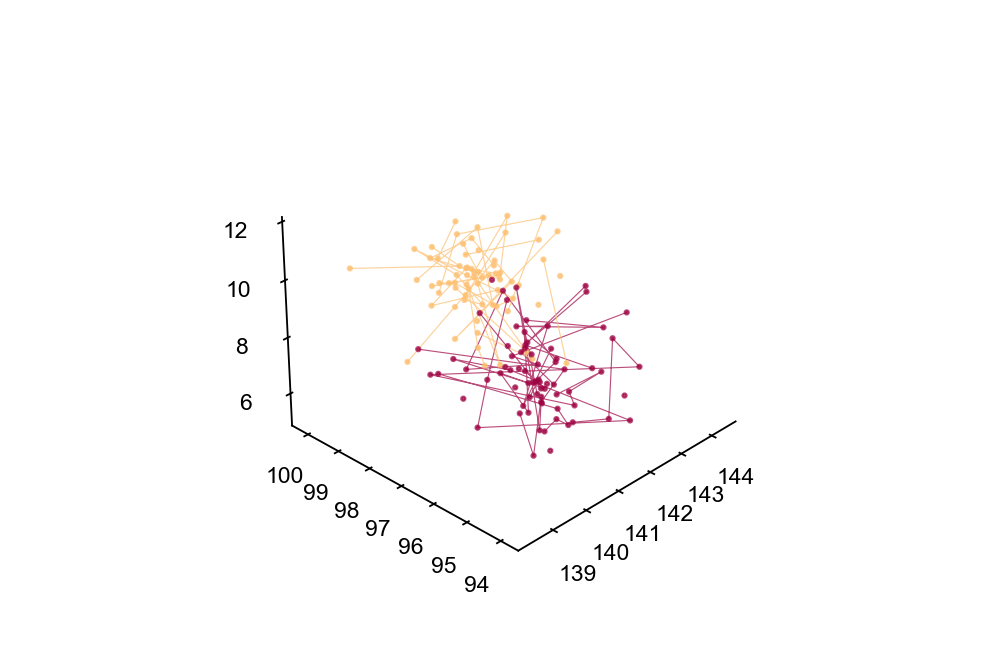

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


In [36]:
%matplotlib notebook
def rotate(angle):
     ax.view_init(azim=angle)
        
from matplotlib import animation

from matplotlib.cm import Reds, Blues, Spectral
fig = plt.figure(dpi=150)
ax = fig.add_subplot(projection='3d')

_chr_name = '11'
_zxys_list = np.array(decoder.chr_2_zxys_list[_chr_name])/1000

for _ichr, _zxys in enumerate(_zxys_list):
    
    ax.scatter(_zxys[:,1], _zxys[:,2], _zxys[:,0],
               cmap=Spectral, 
               c=Spectral(_ichr/(len(_zxys_list)+1)),
               alpha=0.7,
               s=3)

    ax.plot(_zxys[:,1], _zxys[:,2], _zxys[:,0], linewidth=0.5,
            alpha=0.7,
            color = Spectral( _ichr/(len(_zxys_list)+1) ) )
    
ax.grid(False)
ax.xaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
ax.yaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
ax.zaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))

angle = 2
ani = animation.FuncAnimation(fig, rotate, frames=np.arange(0, 360, angle), interval=30)
ani.save(os.path.join(decode_figure_folder, 
                      os.path.basename(decoder.savefile).replace('.hdf5', f'_Picked_chr-{_chr_name}.gif')), 
         writer=animation.PillowWriter(fps=30))

plt.show()

## 3.5 process all

In [73]:
%%time
# old version
import multiprocessing as mp

print(len(decode_args))
with mp.Pool(44) as decode_pool:
    decode_results = decode_pool.starmap(decode.batch_decode_DNA, decode_args, chunksize=1)
    decode_pool.close()
    decode_pool.join()
    decode_pool.terminate()

1630
Wall time: 1min 11s
